In [1]:
import BioSimSpace as BSS

INFO:rdkit:Enabling RDKit 2023.03.3 jupyter extensions


In [2]:
#importing the espaloma ligand 
files = ["input_files/compound_19_copy.gro", "input_files/compound_19_copy.top"]
comp_19_esp = BSS.IO.readMolecules(files)


In [3]:
#importing the protein 
protein = BSS.IO.readMolecules("input_files/protein_b_uncapped.pdb")
loop_b = BSS.IO.readPDB("input_files/protein_b_uncapped.pdb", pdb4amber = True)[0]

In [4]:
#view 1
view = BSS.Notebook.View(comp_19_esp)
view.system()

ThemeManager()

NGLWidget(gui_style='ngl')

In [5]:
#view 2 
view = BSS.Notebook.View(loop_b)
view.system()

NGLWidget(gui_style='ngl')

In [6]:
#parameterisation of amber protein
%env CUDA_VISIBLE_DEVICES=2
process = BSS.Parameters.ff14SB(loop_b, work_dir='param_prot', water_model="tip3p")

#returning the molecule that was parameterised with ff14
ff14_protein = process.getMolecule() 

env: CUDA_VISIBLE_DEVICES=2


In [7]:
complex = ff14_protein + comp_19_esp
view = BSS.Notebook.View(complex)
view.system()

NGLWidget(gui_style='ngl')

In [8]:
#solvation in tip3p water

%env CUDA_VISIBLE_DEVICES=1

# Find the dimensions of the protein
box_min, box_max = protein.getAxisAlignedBoundingBox()

# Work out the box size from the difference in the coordinates.
box_size = [y - x for x, y in zip(box_min, box_max)]

# how much to pad each side of the protein (nonbonded cutoff = 10 A)
padding = 15 * BSS.Units.Length.angstrom

box_length = max(box_size) + 2 * padding

#cmplx = ff14_protein + comp_19_esp

solvated = BSS.Solvent.tip3p(molecule=complex, box=3 * [box_length])


env: CUDA_VISIBLE_DEVICES=1


In [9]:
#viewing the slvated system
view = BSS.Notebook.View(solvated)
view.system()

NGLWidget(gui_style='ngl')

In [10]:
#minimisation
%env CUDA_VISIBLE_DEVICES=1

protocol = BSS.Protocol.Minimisation(steps=5000)
process= BSS.Process.Amber(solvated, protocol,  exe='/usr/local/amber22_test/bin/pmemd.cuda')
process.start()
print(process.getTotalEnergy(block=True))

env: CUDA_VISIBLE_DEVICES=1
-3.2915e+05 kcal/mol


In [11]:
minimised = process.getSystem(block=True)

In [12]:
#equilibration

%env CUDA_VISIBLE_DEVICES=1

protocol= BSS.Protocol.Equilibration(runtime = 0.2 * BSS.Units.Time.nanosecond)
process = BSS.Process.Amber(minimised, protocol, exe='/usr/local/amber22_test/bin/pmemd.cuda', work_dir='equib')
process
process.start()
equilibrated = process.getSystem(block=True)

env: CUDA_VISIBLE_DEVICES=1


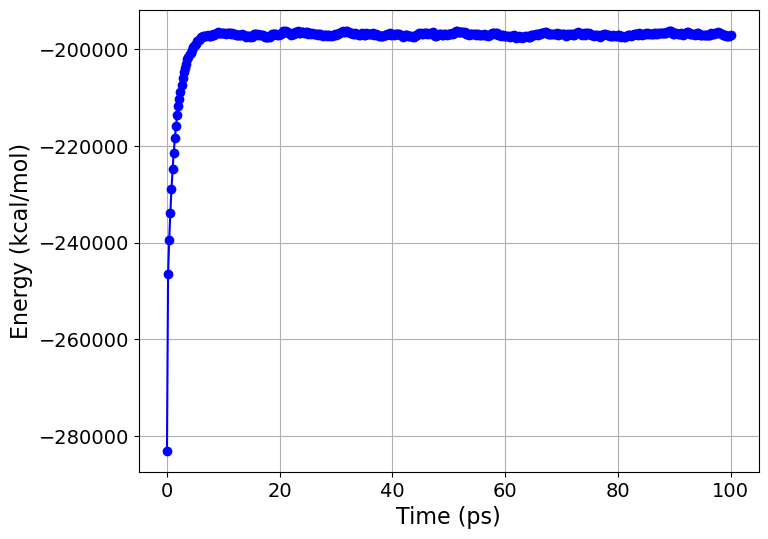

In [13]:
plot = BSS.Notebook.plot(process.getTime(time_series=True), process.getTotalEnergy(time_series=True))

In [14]:
#collecting the data for 100 ns (note:report interval 125000 for the long simulations to get 4000 frames also, insead of 12500)
protocol = BSS.Protocol.Production(timestep=2.0000 * BSS.Units.Time.femtosecond, runtime= 100 * BSS.Units.Time.nanosecond, report_interval = 5000, restart_interval=12500)
process = BSS.Process.Amber(equilibrated, protocol, exe='/usr/local/amber22_test/bin/pmemd.cuda', work_dir='prod_100ns_esp_4000_3')
#process.start()

In [ ]:
#use set-up files by BSS to run slurm script for data production